In [1]:
# imports
import numpy as np
import pandas as pd

In [3]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import preprocessing 

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Operating SYStem stuff
import os

In [9]:
# Get paths for data CSVs
train_path = os.path.join('data', 'titanic_train.csv')
test_path  = os.path.join('data','test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
# gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## Exploratory Data Analysis

In [16]:
#Recommendations for EDA:
#1. Make boxplots of each numerical feature to get visual info about basic statistical info
#2. Make a correlation heatmap of the features to detect multicollinearity
#3. Make pivot tables for categorical features against the target

In [11]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<AxesSubplot:>

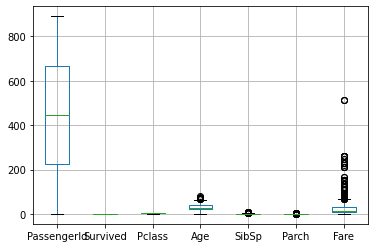

In [14]:
train_df.boxplot()

<AxesSubplot:>

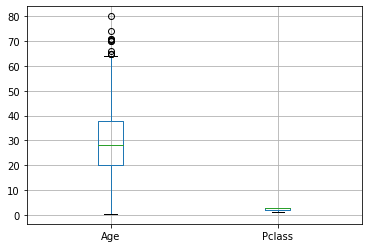

In [15]:
#train_df[['Age','Pclass']].boxplot()

## Preprocessing

In [19]:
# First word is Last Name, so get it and make feature
train_df['LastName'] = train_df['Name'].str.split(',', expand=True)[0]
test_df['LastName'] = test_df['Name'].str.split(',', expand=True)[0]